***Bollinger Bands Strategy Backtest and Optimization.***

In this analysis, we are going to optimize a Bollinger Band strategy with the following trading rules:

1.   Buy when the price crosses below the lower band.
2.   Sell when the price crosses above the upper band.

First, we will create the strategy, and then we will conduct an optimization test to find the best combination of moving average and deviation factor for SPY. After identifying the optimal parameters for SPY, we will test them on a list of other stocks and compare the results. To begin, I will install and download the necessary packages for creating and executing the strategy.

In [ ]:
!pip install quantstats

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import quantstats as qs

Let's create the strategy. The strategy will be encapsulated within a class named 'BacktestingBBands'. This class will contain all the methods necessary to properly backtest the Bollinger Band strategy. It also provides an opportunity to further extend the strategy by creating subclasses.

The strategy will generate plots to verify that it is functioning correctly and to provide statistics on its performance when we are ready to see it. To run the backtest, we only need the ticker symbol of the stock, the start and end dates, the number of days required for the moving average, and the deviation factor to calculate the upper and lower bands.

In [4]:
# Define a class
class BacktestingBBands:

    def __init__(self, ticker, start_date, end_date , ma, dev):
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.ma = ma
        self.dev = dev


        # Call the basic methods in the __init__ constructor itself so that they are automatically executed
        # upon object creation
        self.fetch_data()
        self.indicators()
        self.signals()
        self.positions()
        self.returns()


    def fetch_data(self):
        self.df = yf.download(self.ticker, self.start_date, self.end_date)

    def indicators(self):
        self.df['ma'] = self.df['Adj Close'].rolling(window=self.ma, center=False).mean()
        self.df['std_dev'] = self.df['Adj Close'].rolling(window=self.ma, center=False).std()

    # Calculate upper and lower Bollinger Bands
        self.df['upper_bb'] = self.df['ma'] + (self.df['std_dev'] * self.dev)
        self.df['lower_bb'] = self.df['ma'] - (self.df['std_dev'] * self.dev)

        self.df.dropna(inplace=True)


    def signals(self):
    # Create a 'signal' column initialized with 0
        self.df['signal'] = 0
        self.df.loc[self.df['Adj Close'] < self.df['lower_bb'], 'signal'] = 1
        self.df.loc[self.df['Adj Close'] > self.df['upper_bb'], 'signal'] = -1

    def positions(self):
        self.df['position'] = self.df['signal'].replace(to_replace=0, method='ffill')

    def returns(self):
        self.df['bnh_returns'] = np.log(self.df['Adj Close'] / self.df['Adj Close'].shift(1))
        self.df['strategy_returns'] = self.df['bnh_returns'] * self.df['position'].shift(1)
        print('Total return:', np.round(self.df['strategy_returns'].cumsum()[-1], 2))
        return self.df['strategy_returns'].cumsum()[-1]

    def analysis(self):
        fig, ax1 = plt.subplots(figsize=(15, 6))
        ax1.plot(self.df['Adj Close'], label='Adj Close', color='blue')
        ax1.plot(self.df['upper_bb'], label='Upper BB', color='red')
        ax1.plot(self.df['lower_bb'], label='Lower BB', color='green')
        ax1.legend(loc='upper left')
        ax1.grid(True)
        ax2 = ax1.twinx()
        ax2.plot(self.df['position'], label='Position', color='purple')
        ax2.legend(loc='upper right')
        plt.title('Checking if positions are generated properly')
        plt.show()
        self.df[['bnh_returns','strategy_returns']].cumsum().plot(figsize=(15, 6), grid=True)
        plt.title("Buy & hold' vs 'Bollinger Bands strategy' cumulative returns")
        plt.show()
        qs.reports.basic(self.df['strategy_returns'])

    @staticmethod
    def date_of_backtest():
        print('Date of backtest:', dt.datetime.now().date())

    # A class method
    @classmethod
    def about_this_backtest(cls):
        print('We are backtesting The Bollinger Band Strategy.')


With the strategy established, we can now commence our backtest.

First, we'll create two variables for the start and end dates. The end date will be set to the current date. The start date will be calculated based on the number of available trading days in a year, multiplied by the number of years required for the backtest.

In [5]:
end_date = dt.datetime.now().date()
start_date = end_date - pd.Timedelta(days=3 * 252)

print('Start date:', start_date)
print('End date:', end_date)

Start date: 2021-05-18
End date: 2023-06-13


Now, to execute the backtest, we need to assign the class to a variable that we can call upon. I am choosing 'bbands_test' as the variable name. For the initial backtest, we are going to input the following parameters:

Ticker: SPY
Start Date: start_date
End Date: end_date
Moving Average Days: 20
Deviation Factor for Bands: 2

In [6]:
bbands_test = BacktestingBBands('SPY', start_date, end_date, 20, 2)

[*********************100%***********************]  1 of 1 completed
Total return: 0.02


First Backtest completed! Running the class strategy gives us a print out of the total return based on the parameters we gave it. Another cool feature of the class strategy is that you can see the date and type of strategy running with two clicks of a mouse

In [7]:
bbands_test.about_this_backtest()

We are backtesting The Bollinger Band Strategy.


In [8]:
bbands_test.date_of_backtest()

Date of backtest: 2023-06-13


The 'Strategy' class also includes a feature to generate a tearsheet for reviewing the performance of the strategy. Let's take a look at it below

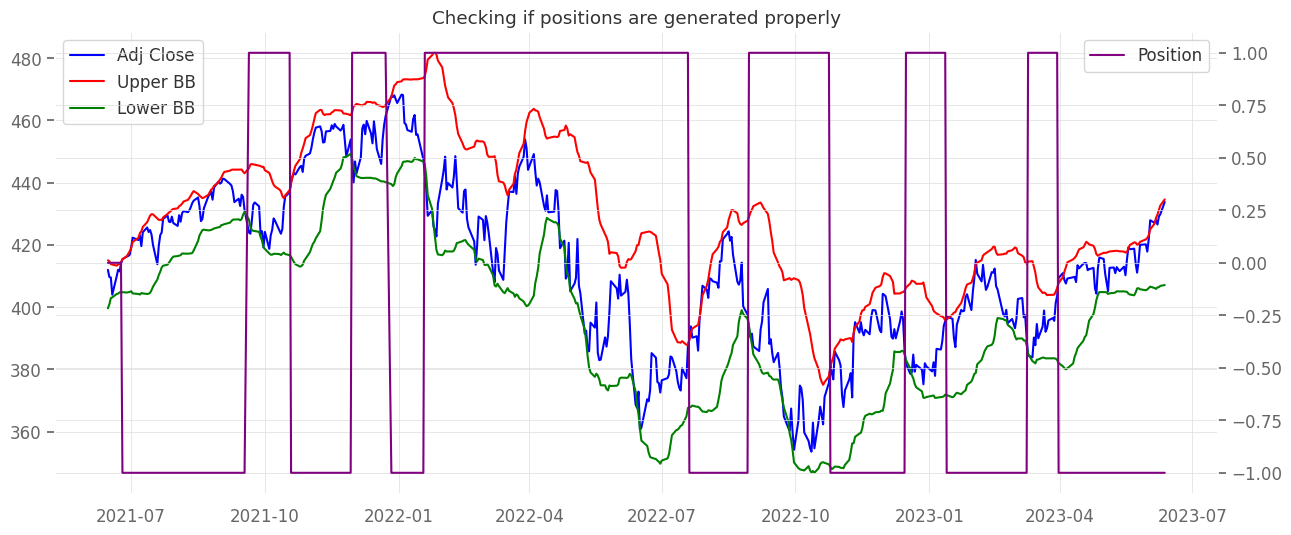

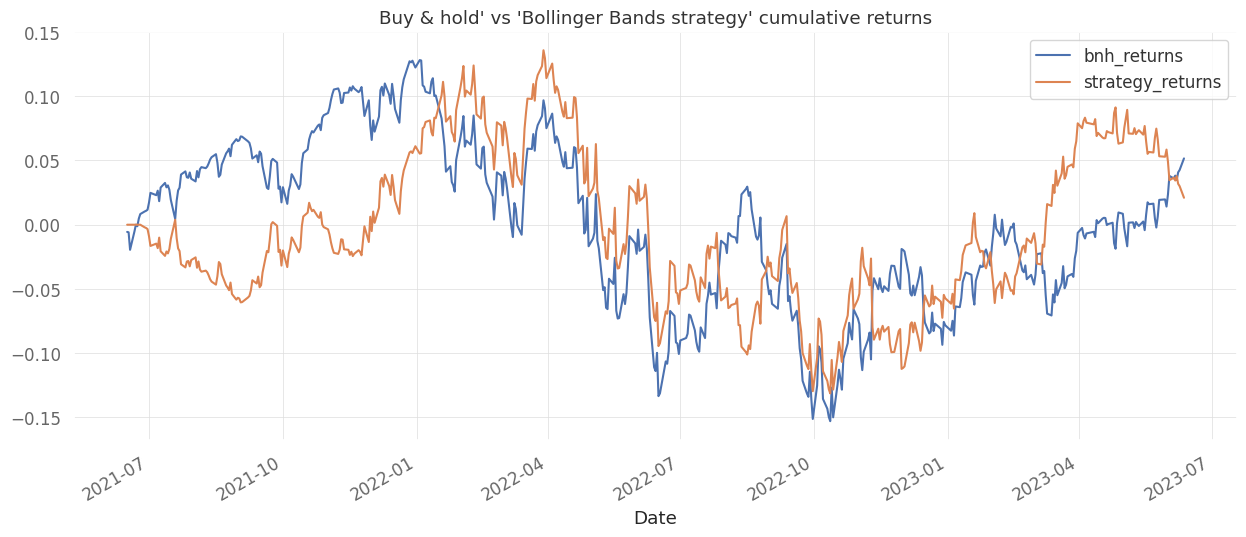

[Performance Metrics]

                    Strategy
------------------  ----------
Start Period        2021-06-15
End Period          2023-06-12
Risk-Free Rate      0.0%
Time in Market      99.0%

Cumulative Return   -1.72%
CAGR﹪              -0.87%

Sharpe              0.05
Prob. Sharpe Ratio  53.02%
Sortino             0.07
Sortino/√2          0.05
Omega               1.01

Max Drawdown        -24.77%
Longest DD Days     439

Gain/Pain Ratio     0.01
Gain/Pain (1M)      0.04

Payoff Ratio        1.04
Profit Factor       1.01
Common Sense Ratio  1.04
CPC Index           0.52
Tail Ratio          1.03
Outlier Win Ratio   2.87
Outlier Loss Ratio  3.92

MTD                 -3.7%
3M                  0.26%
6M                  9.56%
YTD                 7.61%
1Y                  3.38%
3Y (ann.)           -0.87%
5Y (ann.)           -0.87%
10Y (ann.)          -0.87%
All-time (ann.)     -0.87%

Avg. Drawdown       -4.75%
Avg. Drawdown Days  57
Recovery Factor     -0.07
Ulcer Index         0.13
S

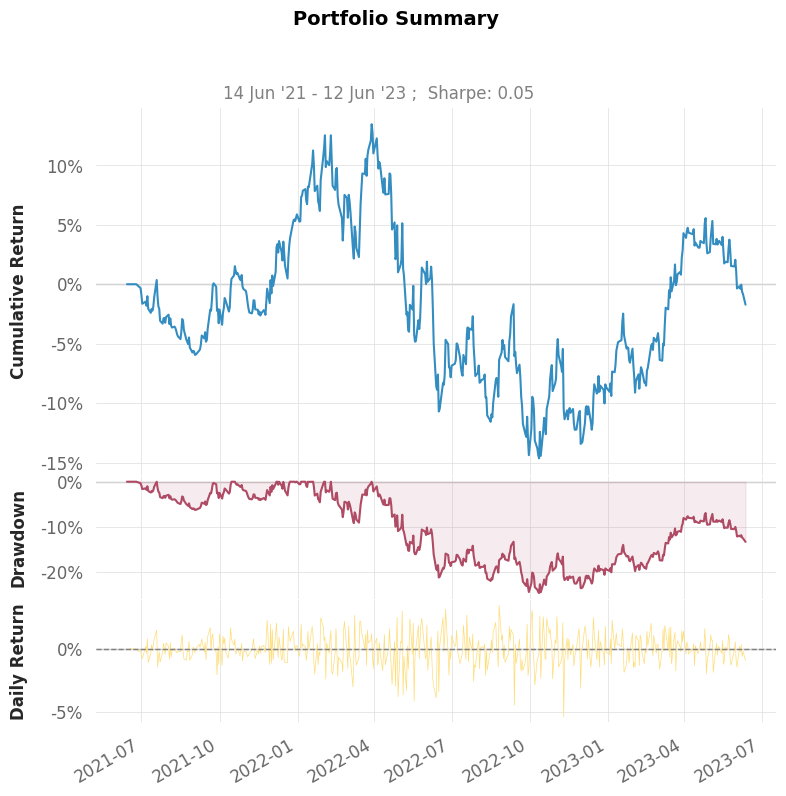

/usr/local/lib/python3.10/dist-packages/quantstats/stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)


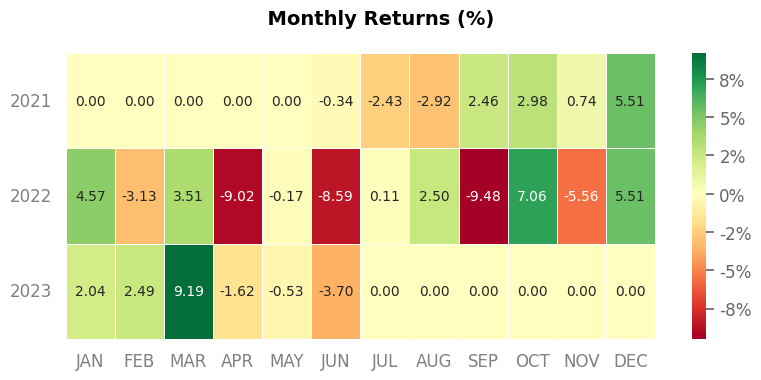

In [9]:
bbands_test.analysis()

What if we want to identify the optimal pair of Moving Average and Deviation Factor that will yield the best returns? Let's conduct an optimization test to find out.

We are testing the following:


1.   Moving Average List: 5, 10, 15, 20, 50
2.   Deviation Factor List: 1, 1.2, 1.4, 1.6, 2

We will create empty lists for moving averages, deviation factors, and net returns from each backtest





In [10]:
ma_list =[5,10,15,20,50]
dev_list =[1,1.2,1.4,1.6,2]

ma =[]
dev =[]
net_returns= []

for i in ma_list:
    for j in dev_list:
        print('For',i,j)
        a = BacktestingBBands('SPY', start_date, end_date, i, j)
        ma.append(i)
        dev.append(j)
        net_returns.append(a.returns())



For 5 1
[*********************100%***********************]  1 of 1 completed
Total return: 0.23
Total return: 0.23
For 5 1.2
[*********************100%***********************]  1 of 1 completed
Total return: 0.26
Total return: 0.26
For 5 1.4
[*********************100%***********************]  1 of 1 completed
Total return: 0.24
Total return: 0.24
For 5 1.6
[*********************100%***********************]  1 of 1 completed
Total return: 0.12
Total return: 0.12
For 5 2
[*********************100%***********************]  1 of 1 completed
Total return: 0.0
Total return: 0.0
For 10 1
[*********************100%***********************]  1 of 1 completed
Total return: 0.12
Total return: 0.12
For 10 1.2
[*********************100%***********************]  1 of 1 completed
Total return: -0.0
Total return: -0.0
For 10 1.4
[*********************100%***********************]  1 of 1 completed
Total return: 0.18
Total return: 0.18
For 10 1.6
[*********************100%***********************]  1 of 1

We have our results, but they're a bit difficult to read. Let's clean them up and sort them to see which combination of moving average and deviation factor produces the highest return.

In [11]:
results = pd.DataFrame({'ma':ma, 'dev': dev, 'net_returns':net_returns})
results = results.sort_values(by='net_returns', ascending=False)
results

,ma,dev,net_returns
8,10,1.6,0.346765
22,50,1.4,0.319068
1,5,1.2,0.255396
24,50,2.0,0.255027
23,50,1.6,0.253645
2,5,1.4,0.244165
21,50,1.2,0.234497
0,5,1.0,0.231131
14,15,2.0,0.210701
7,10,1.4,0.179083


Based on this backtest, the pair yielding the best returns is a moving average of 10 and a deviation factor of 1.6. Now, let's see how this pair performs with different stocks. Below is a list of stock tickers. The script will backtest each ticker and store the returns in the empty 'net_returns' list. It will print the stock name along with its total return

In [12]:
stock_list = [   'PSEC',
                 'AAPL',
                 'NVDA',
                 'APRN',
                 'MSFT',
                 'SIEN',
                 'AMZN',
                 'CVNA',
                 'TGT',
                 'O',
                 'META',
                 'AHI'  ]


stock_name = []
net_returns1 = []

In [13]:
for stock in stock_list:

        print('Backtesting result for', stock)

        a = BacktestingBBands(stock, start_date, end_date, 10, 1.6)

        stock_name.append(stock)

        net_returns1.append(a.returns())


Backtesting result for PSEC
[*********************100%***********************]  1 of 1 completed
Total return: -0.34
Total return: -0.34
Backtesting result for AAPL
[*********************100%***********************]  1 of 1 completed
Total return: -0.49
Total return: -0.49
Backtesting result for NVDA
[*********************100%***********************]  1 of 1 completed
Total return: -0.77
Total return: -0.77
Backtesting result for APRN
[*********************100%***********************]  1 of 1 completed
Total return: 0.76
Total return: 0.76
Backtesting result for MSFT
[*********************100%***********************]  1 of 1 completed
Total return: 0.54
Total return: 0.54
Backtesting result for SIEN
[*********************100%***********************]  1 of 1 completed
Total return: -0.95
Total return: -0.95
Backtesting result for AMZN
[*********************100%***********************]  1 of 1 completed
Total return: -0.19
Total return: -0.19
Backtesting result for CVNA
[****************

Again, the backtest results are a bit difficult to interpret. Let's do what we did previously and clean them up for easier reading.

In [14]:
results1 = pd.DataFrame({'Stock Name':stock_name, 'net_returns':net_returns1})
results1 = results1.sort_values(by='net_returns', ascending=False)

In [15]:
results1

,Stock Name,net_returns
3,APRN,0.756127
11,AHI,0.688134
4,MSFT,0.536087
10,META,0.015598
6,AMZN,-0.189141
9,O,-0.317957
0,PSEC,-0.339046
8,TGT,-0.398783
1,AAPL,-0.485331
2,NVDA,-0.767072


Based on this backtest, I ask myself the following:




1.   For the past three years, utilizing the Bollinger Bands on Blue Apron Holdings (APRN) would have produced some decent returns. I wonder why that is? What about APRN made it a good fit for the Bollinger Band strategy? In fact, I would want to know why the top four stocks listed above produced the returns they did.

2.   For the stocks that yielded negative returns, is it possible to tweak the current strategy so that positive returns are achieved? Perhaps a different Moving Average and Deviation Factor combination would work better?





